## Siamese Neural Network

* Here you will create a SNN to compare images of people


## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from sklearn.datasets import fetch_olivetti_faces

## Download the dataset

API: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html

Load the Olivetti faces data-set from AT&T (classification).

There are 400 images represented as a vector. So each image is actually (64,64)

In [ ]:
faces, targets = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=42)
n_samples, n_features = faces.shape

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [ ]:
faces.shape

(400, 4096)

In [ ]:
faces[0].shape

(4096,)

In [ ]:
targets.shape

(400,)

## Split into training and testing

Set aside 33% for testing and use a seed of 42.

You should get the following shapes:

```
(268, 4096)
(268,)
(132, 4096)
(132,)
```



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
faces, targets, test_size=0.33, random_state=42)

## Check shapes

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(268, 4096)
(268,)
(132, 4096)
(132,)


## Generate pairs

This function will generate pairs, thus each element will be two images and the target.

In [ ]:
def generate_train_image_pairs(images_dataset, labels_dataset):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels_dataset) if
                                       label == curr_label])
    
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images_dataset):
        pos_indices = label_wise_indices.get(labels_dataset[index])
        pos_image = images_dataset[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels_dataset != labels_dataset[index])
        neg_image = images_dataset[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)
    return np.array(pair_images), np.array(pair_labels)

## Generate training and testing pairs

In [ ]:
X_train_pair, y_train_pair = generate_train_image_pairs(X_train, y_train)
X_test_pair, y_test_pair = generate_train_image_pairs(X_test, y_test)

The shape is `(536,2,4096)` so there are 536 training data points. Each data point contains two images. Even indexed data points correspond to similar pairs, and odd indices correspond to disimilar pairs. This is why there is a "2" in the shape, the first for image one in the pair, and the second for image 2 in the pair.

In [ ]:
X_train_pair.shape

(536, 2, 4096)

## Visualise some pairs

Try to modify the code from the previous practical. Hint:



```
fig, m_axs = plt.subplots(2, 8, figsize = (25, 12))
for c_a, c_b, (ax1, ax2) in zip(X_train_pair, y_train_pair,m_axs.T):
# to do
```

This will display 8 pairs.


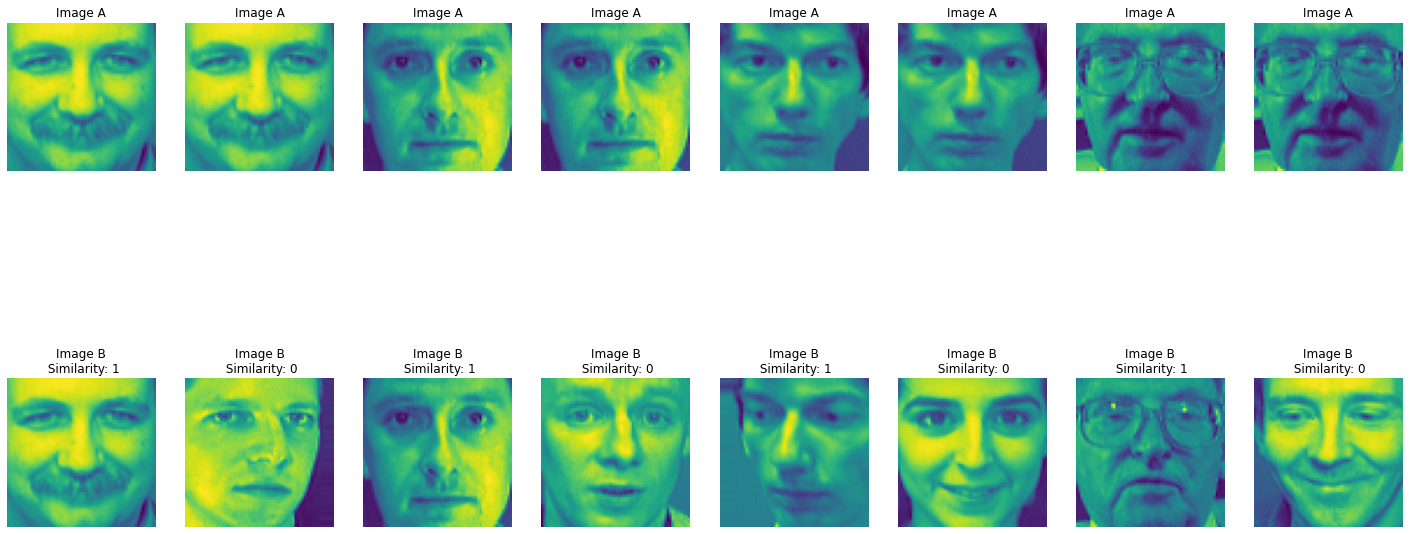

In [ ]:
fig, m_axs = plt.subplots(2, 8, figsize = (25, 12))
for c_a, c_b, (ax1, ax2) in zip(X_train_pair, y_train_pair,m_axs.T):

    # Display the first image in the pair
    ax1.set_title('Image A')
    ax1.imshow(np.reshape(c_a[0], (64,64)))
    ax1.axis('off')

    # Display the second image in the pair
    ax2.set_title('Image B\n Similarity: ' + str(c_b))
    ax2.imshow(np.reshape(c_a[1], (64,64)))
    ax2.axis('off')

## Now we create the feature extractor

Note that the two feature extractors are the same. But we only need to create this once and we will re-use it twice later on when we combine the two together.

In [ ]:
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout

# Define the input
input = Input(shape = (64,64,1), name = 'FeatureNet_ImageInput')

# Now the conv, batch norm and pooling layers...
x = Conv2D(8, kernel_size = (3,3))(input)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(16, kernel_size = (3,3))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool2D((2,2))(x)

x = Conv2D(16, kernel_size = (3,3))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(32, kernel_size = (3,3))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool2D((2,2))(x)

x = Flatten()(x)
x = Dense(32, activation = 'linear')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Activation('relu')(x)

Now we create the feature extractor

In [ ]:
feature_model = Model(inputs = [input], outputs = [output], name = 'FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeatureNet_ImageInput (Inpu  [(None, 64, 64, 1)]      0         
 tLayer)                                                         
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 8)         80        
                                                                 
 batch_normalization_7 (Batc  (None, 62, 62, 8)        32        
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 62, 62, 8)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        1168      
                                                                 
 batch_normalization_8 (Batc  (None, 60, 60,

## Now time to make the SNN

In [ ]:
# Input for images going into group A
sns_input_a = Input(shape = (64,64,1), name = 'ImageA_Input')

# Input for images going into group B
sns_input_b = Input(shape = (64,64,1), name = 'ImageB_Input')

# Get the embedding output for group A branch
embedding_a = feature_model(sns_input_a)

# Get the embedding output for group B branch
embedding_b = feature_model(sns_input_b)

# Combine the embeddings together
combined_features = concatenate([embedding_a, embedding_b], name = 'merge_features')

# Normal MLP layers next
combined_features = Dense(16)(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

# The output here is represented as the sigmoid output
snn_output = Dense(1, activation = 'sigmoid')(combined_features)

### Create the full model

In [ ]:
similarity_model = Model(inputs = [sns_input_a, sns_input_b], 
                         outputs = [snn_output], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 FeatureGenerationModel (Functi  (None, 32)          181712      ['ImageA_Input[0][0]',           
 onal)                                                            'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 64)           0           ['FeatureGeneratio

### Compile

In [ ]:
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

## Pre-processing

The data needs to be reshaped to represent images (width, height and depth).

The shape of the training pairs (features) is `(536, 2, 4096)`. What we want is `(536, 2, 64, 64, 1)`.

In [ ]:
X_train_pair.shape, y_train_pair.shape

((536, 2, 4096), (536,))

In [ ]:
X_train_pair = np.reshape(X_train_pair, (X_train_pair.shape[0], 
                                       X_train_pair.shape[1], 
                                       64,64,1))

X_test_pair = np.reshape(X_test_pair, (X_test_pair.shape[0], 
                                       X_test_pair.shape[1], 
                                       64,64,1))

In [ ]:
X_train_pair.shape, y_train_pair.shape

((536, 2, 64, 64, 1), (536,))

In [ ]:
X_test_pair.shape, y_test_pair.shape

((264, 2, 64, 64, 1), (264,))

To train the network, we need to provide the two inputs (input1 and input 2). 

Since each datapoint is a pair of images, we need to be able to access each one.

The one input will have shape: `(536, 64, 64, 1)` and the other will also be `(536, 64, 64, 1)`

In [ ]:
X_train_pair[:,0,:].shape

(536, 64, 64, 1)

In [ ]:
X_train_pair[:,1,:].shape

(536, 64, 64, 1)

### Train the model

In [ ]:
loss_history = similarity_model.fit([X_train_pair[:,0,:], X_train_pair[:,1,:]], y_train_pair,
                                      epochs = 75,verbose = True)

Epoch 1/75
17/17 [==============================] - 2s 15ms/step - loss: 0.7532 - mae: 0.5070
Epoch 2/75
17/17 [==============================] - 0s 12ms/step - loss: 0.7269 - mae: 0.4982
Epoch 3/75
17/17 [==============================] - 0s 12ms/step - loss: 0.7246 - mae: 0.4987
Epoch 4/75
17/17 [==============================] - 0s 11ms/step - loss: 0.6988 - mae: 0.4891
Epoch 5/75
17/17 [==============================] - 0s 11ms/step - loss: 0.6838 - mae: 0.4839
Epoch 6/75
17/17 [==============================] - 0s 11ms/step - loss: 0.6769 - mae: 0.4801
Epoch 7/75
17/17 [==============================] - 0s 12ms/step - loss: 0.6620 - mae: 0.4732
Epoch 8/75
17/17 [==============================] - 0s 12ms/step - loss: 0.6796 - mae: 0.4814
Epoch 9/75
17/17 [==============================] - 0s 11ms/step - loss: 0.6678 - mae: 0.4763
Epoch 10/75
17/17 [==============================] - 0s 11ms/step - loss: 0.6640 - mae: 0.4738
Epoch 11/75
17/17 [==============================] - 0s 11m

## Inference

To do this we need to provide the one batch if we want to predict in a single image. To test on a single image we need to add a new dimension in front to create a batch size of 1.

Predict on the second testing data point.

In [ ]:
X_test_pair[0,0,:].shape

(64, 64, 1)

In [ ]:
X_test_pair[tf.newaxis,0,0,:].shape

(1, 64, 64, 1)

In [ ]:
similarity_model.predict([X_test_pair[tf.newaxis,2,0,:],
                          X_test_pair[tf.newaxis,2,1,:]])

array([[0.77857864]], dtype=float32)

## Predicting on a small batch

Hint: 

```
fig, m_axs = plt.subplots(2, 8, figsize = (25, 12))
for c_a, c_b, (ax1, ax2) in zip(X_test_pair, y_test_pair,m_axs.T):
# TO do
```



(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)


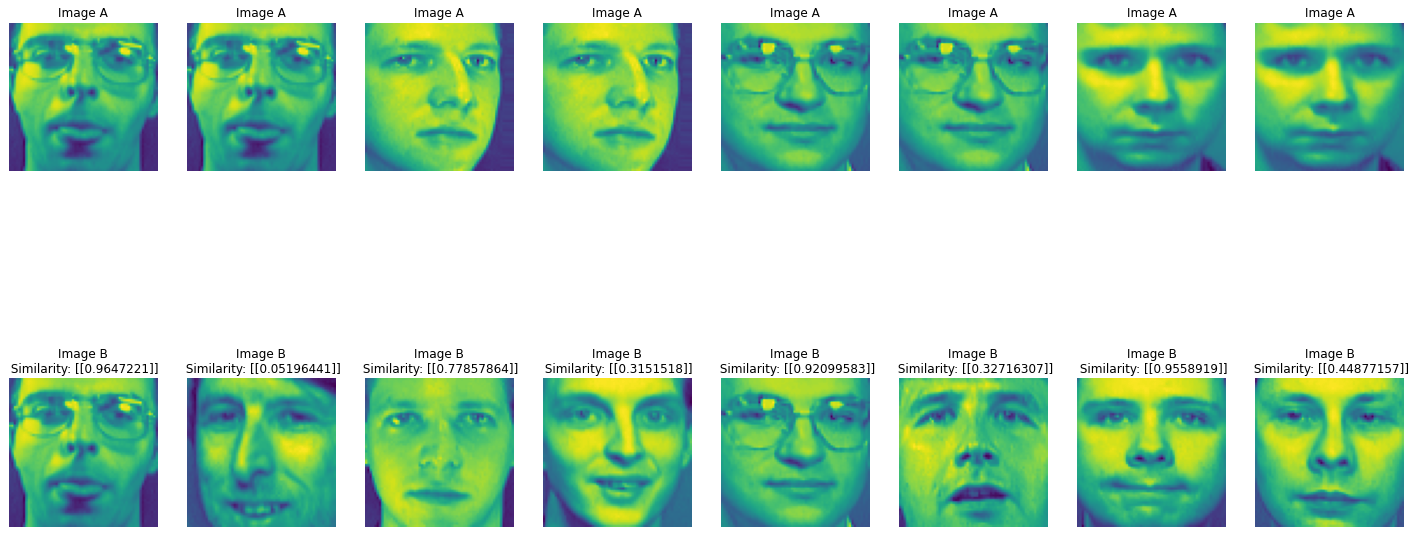

In [ ]:
fig, m_axs = plt.subplots(2, 8, figsize = (25, 12))
for c_a, c_b, (ax1, ax2) in zip(X_test_pair, y_test_pair,m_axs.T):

    print(c_a[tf.newaxis,0,:].shape)
    pred_sim = similarity_model.predict([c_a[tf.newaxis,0,:],
                          c_a[tf.newaxis,1,:]])

    ax1.set_title('Image A')
    ax1.imshow(np.reshape(c_a[0], (64,64)))
    ax1.axis('off')
    ax2.set_title('Image B\n Similarity: ' + str(pred_sim))
    ax2.imshow(np.reshape(c_a[1], (64,64)))
    ax2.axis('off')